In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets,transforms,utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

In [31]:
torch.manual_seed(42)
batch_size = 128
lr = 1e-4
epochs = 10
noise_sigma = 0.2
latent_dim = 128
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [32]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root="./data",train=True,download=True,transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size,num_workers=2,pin_memory=True)

In [33]:
'''🔹 2. Variational Autoencoder (fc_mu and fc_logvar)
🎯 Purpose:

Instead of mapping to a single latent vector, VAEs map to a probability distribution (mean and variance).

This allows sampling from the latent space, enabling generative capabilities'''

# ConvVAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(inplace=True),  # 16x16
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(inplace=True), # 8x8
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(inplace=True) # 4x4
        )
        self.flat = nn.Flatten()              # 128*4*4=2048
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_logvar = nn.Linear(2048, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 2048)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(inplace=True), # 8x8
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(inplace=True),  # 16x16
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()             # 32x32, [0,1]
        )

    def encode(self, x):
        h = self.enc(x)
        h = self.flat(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, 4, 4)
        x = self.dec(h)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
def vae_loss(recon, x, mu, logvar):
    # Reconstruction: BCE over pixels in [0,1]
    bce = nn.functional.binary_cross_entropy(recon, x, reduction="sum")
    # KL: D_KL(q(z|x) || N(0, I))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (bce + kld), bce, kld

model = ConvVAE(latent_dim).to(device)
opt = optim.Adam(model.parameters(), lr=lr)

# Train
for epoch in range(1, epochs+1):
    model.train()
    total, total_bce, total_kld = 0.0, 0.0, 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        opt.zero_grad()
        recon, mu, logvar = model(imgs)
        loss, bce, kld = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        opt.step()
        total += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()
    n = len(train_loader.dataset)
    print(f"Epoch {epoch:02d}/{epochs} | Loss: {total/n:.4f} | BCE: {total_bce/n:.4f} | KLD: {total_kld/n:.4f}")

Epoch 01/10 | Loss: 2016.1946 | BCE: 2001.7352 | KLD: 14.4594
Epoch 02/10 | Loss: 1912.4471 | BCE: 1884.5772 | KLD: 27.8699
Epoch 03/10 | Loss: 1886.4539 | BCE: 1855.7567 | KLD: 30.6971
Epoch 04/10 | Loss: 1866.9010 | BCE: 1834.9057 | KLD: 31.9953
Epoch 05/10 | Loss: 1857.9641 | BCE: 1825.4387 | KLD: 32.5253
Epoch 06/10 | Loss: 1851.1664 | BCE: 1817.8038 | KLD: 33.3625
Epoch 07/10 | Loss: 1846.1960 | BCE: 1812.1524 | KLD: 34.0436
Epoch 08/10 | Loss: 1842.5342 | BCE: 1807.7710 | KLD: 34.7631
Epoch 09/10 | Loss: 1839.6476 | BCE: 1804.1922 | KLD: 35.4554
Epoch 10/10 | Loss: 1837.4133 | BCE: 1801.3563 | KLD: 36.0570


In [ ]:
'''bce = nn.functional.binary_cross_entropy(recon, x, reduction="sum")

This calculates the Reconstruction Loss — how well the model reconstructs the input.

binary_cross_entropy (BCE) compares the original pixels x with the reconstructed pixels recon.

It measures the difference pixel by pixel assuming pixel values are probabilities (between 0 and 1).

reduction="sum" means it sums over all pixels and batch samples to get total loss.

Lower BCE → better reconstruction

3. kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

This is the KL Divergence Loss, a regularization term.

It measures how much the learned latent distribution q(z|x) = N(mu, sigma²) differs from the standard normal distribution N(0, 1).

Breaking it down:

1 + logvar - mu.pow(2) - logvar.exp() is the formula inside the KL divergence.

torch.sum(...) sums over all latent dimensions and batch samples.

Multiplying by -0.5 adjusts the scale.

Lower KLD → latent space closer to normal distribution

This term prevents overfitting by keeping the latent space well-behaved and smooth.'''

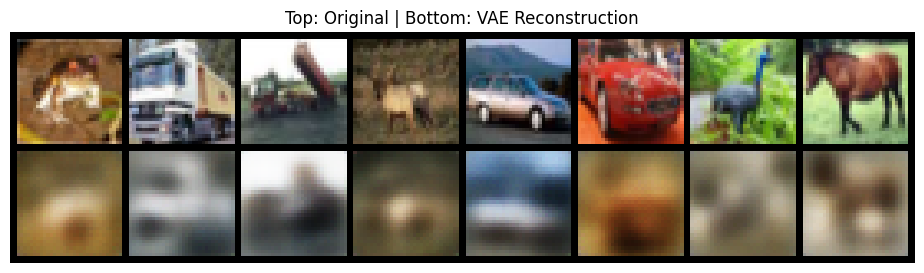

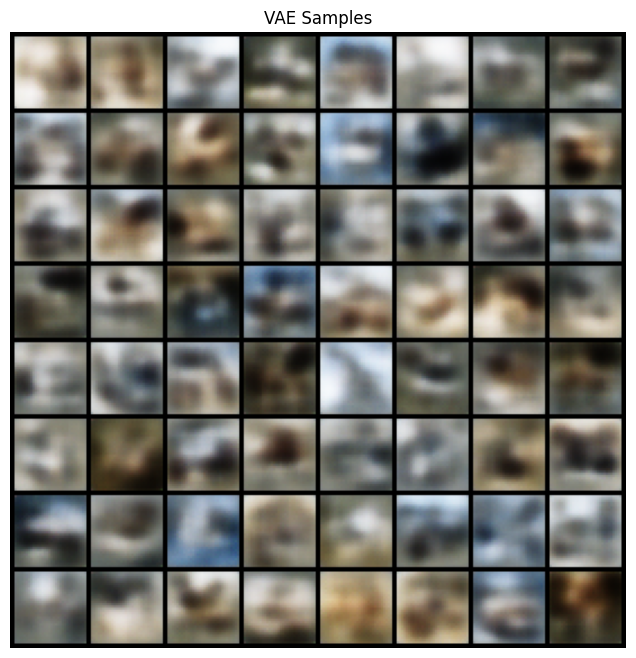

In [34]:
model.eval()
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)
with torch.no_grad():
    recon, _, _ = model(imgs)

grid = utils.make_grid(torch.cat([imgs[:8], recon[:8]], dim=0), nrow=8)
plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.title("Top: Original | Bottom: VAE Reconstruction")
plt.show()

# Sample from latent and generate new images
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    samples = model.decode(z).cpu()
grid = utils.make_grid(samples, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).numpy())
plt.axis("off")
plt.title("VAE Samples")
plt.show()